In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline


## Original Organics formulation

In [2]:
Wzx = np.matrix('-0.5, 0, 0, 0; \
                -0.3536 -0.3536 0 0; \
                0 0.5 0 0; \
                0.3536 0.3536 0 0;\
                0.5 0 0 0;\
                0.3536 -0.3536 0 0;\
                0 -0.5 0 0; \
                -0.3536 -0.3536 0 0')

Wax = np.matrix('0 0 1 1; 0 0 1 1;\
                0 0 1 1; 0 0 1 1;\
                0 0 1 1; 0 0 1 1;\
                0 0 1 1; 0 0 1 1')

Wbx = np.matrix('0 0 1 0; 0 0 1 0;\
                0 0 1 0; 0 0 1 0;\
                0 0 1 0; 0 0 1 0;\
                0 0 1 0; 0 0 1 0')

num = np.cos(np.pi / 4)
Wyy = 0.25 * np.matrix([[1, num, 0, -num, -1, -num, 0, num],
                [num, 1, num, 0, -num, -1, -num, 0],
                [0, num, 1, num, 0, -num, -1, -num],
                [-num, 0, num, 1, num, 0, -num, -1],
                [-1, -num, 0, num, 1, num, 0, -num],
                [-num, -1, -num, 0, num, 1, num, 0],
                [0, -num, -1, -num, 0, num, 1, num],
                [num, 0, -num, -1, -num, 0, num, 1]])



Way = 0
Wby = 0
cz = 0
ca = 0
cb = 0
cy = 0

# Time constants in ms
ta = 10 
tb = 10
ty = 10
dt = 10

In [3]:
U,V = np.linalg.eig(Wyy)

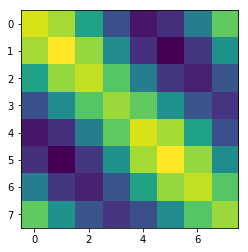

In [4]:
A = V * np.diag(U) * V.T
plt.imshow(A)
plt.show()

In [5]:
posx = [0.0] * 25 + [0.2] * 75 + [0.0] * 300
posy = [0.0] * 25 + [-0.5] * 75 + [0.0] * 300
begin = [1.0] * 75 + [0.0] * 325
delay = [0.0] * 300 + [1.0] * 25 + [0.0] * 75

x_mat = np.matrix([posx, posy, begin, delay])


In [6]:
y = np.matrix([0.0] * 8).T
a = np.matrix([0.0] * 8).T
b = np.matrix([0.0] * 8).T
y = np.matrix([0.0] * 8).T

ymat = [y.copy()]
amat = [a.copy()]
bmat = [b.copy()]
ymat = [y.copy()]
zmat = []

for i in range(200):
    z = Wzx * x_mat[:, i]
    yhat = Wyy * y + cy
    da = dt / ta * (-a + Wax * x_mat[:,i] + Way * y + ca)
    a += da
    
    #print(np.sum(a))
    #import pdb; pdb.set_trace()
    #from IPython.core.debugger import Tracer; Tracer()()
    
    
    db = dt / tb * (-b + Wbx * x_mat[:,i] + Wby * y + cb)
    b += db
    
    bp =  np.maximum(b, 0)
    ap = np.maximum(a, 0)
    
    dy = dt / ty * (-y + np.multiply(bp / (1 + bp),  z) + \
                    np.multiply((1 / (1 + ap)), yhat)) 
    y += dy
    
    amat.append(a.copy())
    #print(np.sum(amat))
    bmat.append(b.copy())
    ymat.append(y.copy())
    zmat.append(z.copy())

Amat = np.hstack(amat)
Bmat = np.hstack(bmat)
Ymat = np.hstack(ymat)
Zmat = np.hstack(zmat)

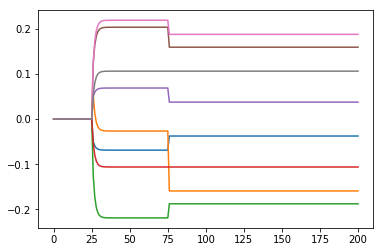

In [7]:
# Plot of Y traces!
plt.plot(Ymat.T);

## Trying to have Organics maintain a state

Holding can be achieved by setting `Wyy = 1` (identity matrix)

In [8]:
Wyy = 1

y = np.matrix([0.0] * 8).T
a = np.matrix([0.0] * 8).T
b = np.matrix([0.0] * 8).T
y = np.matrix([0.0] * 8).T

ymat = [y.copy()]
amat = [a.copy()]
bmat = [b.copy()]
ymat = [y.copy()]
zmat = []

for i in range(400):
    z = Wzx * x_mat[:, i]
    yhat = Wyy * y + cy
    da = dt / ta * (-a + Wax * x_mat[:,i] + Way * y + ca)
    a += da
    
    #print(np.sum(a))
    #import pdb; pdb.set_trace()
    #from IPython.core.debugger import Tracer; Tracer()()
    
    
    db = dt / tb * (-b + Wbx * x_mat[:,i] + Wby * y + cb)
    b += db
    
    bp =  np.maximum(b, 0)
    ap = np.maximum(a, 0)
    
    dy = dt / ty * (-y + np.multiply(bp / (1 + bp),  z) + \
                    np.multiply((1 / (1 + ap)), yhat)) 
    y += dy
    
    amat.append(a.copy())
    #print(np.sum(amat))
    bmat.append(b.copy())
    ymat.append(y.copy())
    zmat.append(z.copy())

Amat = np.hstack(amat)
Bmat = np.hstack(bmat)
Ymat = np.hstack(ymat)
Zmat = np.hstack(zmat)

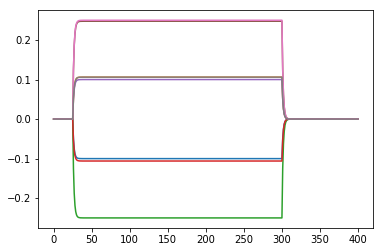

In [9]:
plt.plot(Ymat.T);

## Gating of two-neuron module

In [10]:
# Common parameters used for the entire file
param_dict_no_theta = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.6, 'tau': 100, 'dt': 10, 'ext': 0, 'sigma': 0.1}

param_dict_theta = {'Wut': 6, 'Wvt': 6, 'Wuv': 6, 'Wvu': 6,
              'theta': 0.8, 'tau': 100, 'dt': 10, 'ext': 0, 'sigma': 0.1}

state_dict = {'u': 1, 'v': 0}

In [11]:
def ecdf(x):
    return np.sort(x), np.arange(len(x)) / len(x)

def save_safe(filename):
    '''Raise an error if file exists'''
    if not os.path.isfile(filename):
        plt.savefig(filename)
    else:
        raise IOError('File exists!')

def thresh_exp(x):
    '''Activation function'''
    return 1 / (1 + np.exp(-x))

def find_u_dot(state, params):
    '''Returns du/dt given the parameters and current state'''
    Wuv = params['Wuv']
    Wut = params['Wut']
    tau = params['tau']
    ext = params['ext']
    theta = params['theta']
    
    u = state['u']
    v = state['v']
    return (-u + thresh_exp(Wut * theta - Wuv * v + ext)) / tau

def find_v_dot(state, params):
    '''Returns dv/dt given the parameters and current state'''
    Wvu = params['Wvu']
    Wvt = params['Wvt']
    tau = params['tau']
    ext = params['ext']
    theta = params['theta']

    
    u = state['u']
    v = state['v']
    return (-v + thresh_exp(Wvt * theta - Wvu * u + ext)) / tau

def update_u_exp(state, params):
    '''Update u based on params'''
    state_new = state.copy()
    state_new['u'] += find_u_dot(state, params) * params['dt']
    return state_new

def update_v_exp(state, params):
    '''Update v based on params'''
    state_new = state.copy()
    state_new['v'] += find_v_dot(state, params) * params['dt']
    return state_new

def simulate_u_v_exp(state_init, params, niter):
    '''Simulate for niter iterations'''
    curr_state = state_init.copy()
    u_lst = [state_init['u']]
    v_lst = [state_init['v']]

    for i in range(niter):
        order = np.random.randint(0, 2)
        if order:
            curr_state = update_u_exp(curr_state, params)    
            curr_state = update_v_exp(curr_state, params)
        else:
            curr_state = update_v_exp(curr_state, params)    
            curr_state = update_u_exp(curr_state, params)
        v_lst.append(curr_state['v'])
        u_lst.append(curr_state['u'])
    return u_lst, v_lst

In [12]:
def thresh_exp(x):
    '''Activation function'''
    return 1 / (1 + np.exp(-x))

In [13]:
def start_simulation(state_init, acoefs, niter):
    # Parameters of the simulation
    # TODO: put these into input of function
    Wut = 6
    Wuv = 6
    Wvt = 6
    Wvu = 6
    dt = 10
    tau = 100
    ext = 0
    y0 = 0.7 #The target value of y
    K = 0.2
    
    
    # Unpack variables
    I = state_init[0]
    Iref = state_init[1]
    u = state_init[2]
    v = state_init[3]
    y = state_init[4]
    
    aI = acoefs[0]
    ay = acoefs[1]
    aR = acoefs[2]
    
    
    u_lst = []
    v_lst = []
    y_lst = []
    
    for i in range(niter):
        # I update here:
        I += -I + aI * (Iref - K * (y0 - y)) + (1 - aI) * I
        Iref += -Iref + aR * I + (1 - aR) * Iref

        # u-v and y update
        u += (-u + thresh_exp(Wut * I - Wuv * v + ext)) / tau * dt
        v += (-v + thresh_exp(Wvt * I - Wvu * u + ext)) / tau * dt
        y += -y + ay * (u - v) + (1 - ay) * y

        v_lst.append(v)
        u_lst.append(u)
        y_lst.append(y)
        
    return u_lst, v_lst, y_lst, I, Iref

In [14]:
state_init = [0.8, 0.8, 0.7, 0.2, 0.5]
acoefs = np.array([0.0, 1.0, 1.0])
ulst, vlst, ylst, I, Iref = start_simulation(state_init, acoefs, 50)

# Flip the coefs
for k in range(30):
    acoefs = 1 - acoefs
    state_init = [I, Iref, ulst[-1], vlst[-1], ylst[-1]]
    ulst2, vlst2, ylst2, I, Iref = start_simulation(state_init, acoefs, 50)

    ulst += ulst2
    vlst += vlst2
    ylst += ylst2




In [15]:
acoefs

array([0., 1., 1.])

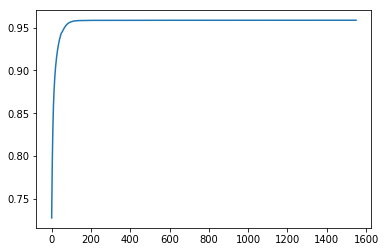

In [16]:
plt.plot(ulst)

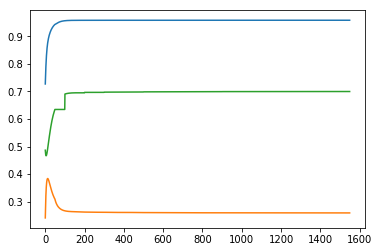

In [17]:
plt.plot(ulst)
plt.plot(vlst)
plt.plot(ylst)

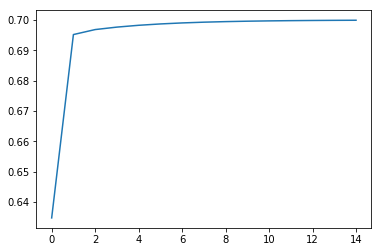

In [18]:
plt.plot(ylst[50::100])

In [27]:
# Find fixed points for high theta
# Some parameters
u = 0.7
v = 0.2

Wut = 6
Wuv = 6
Wvt = 6
Wvu = 6
dt = 10
tau = 100
I = 0.8
Iref = 0.8
ext = 0

u_lst = []
v_lst = []
y_lst = []

y0 = 0.7 #The target value of y
aI = 0
ay = 1
aR = 1
K = 0.1

In [28]:
u

0.7

In [25]:
# I is clamped
for i in range(50):
    # I update here:
    I += -I + aI * (Iref - K * (y0 - y)) + (1 - aI) * I
    Iref += -Iref + aR * I + (1 - aR) * Iref
    
    # u-v and y update
    u += (-u + thresh_exp(Wut * I - Wuv * v + ext)) / tau * dt
    v += (-v + thresh_exp(Wvt * I - Wvu * u + ext)) / tau * dt
    y += -y + ay * (u - v) + (1 - ay) * y
    
    v_lst.append(v)
    u_lst.append(u)
    y_lst.append(y)

    
    

In [32]:
y

matrix([[0.63472081],
        [0.63472081],
        [0.63472081],
        [0.63472081],
        [0.63472081],
        [0.63472081],
        [0.63472081],
        [0.63472081]])

ValueError: x and y can be no greater than 2-D, but have shapes (100,) and (100, 8, 1)

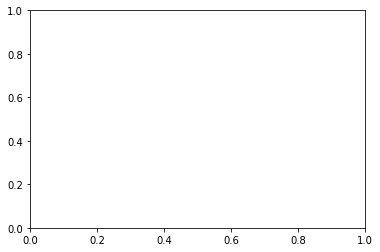

In [22]:
ay = 0
aR = 0
aI = 1
# y is clamped, I gets updated

for i in range(50):
    # I update here:
    I += -I + aI * (Iref - K * (y0 - y)) + (1 - aI) * I
    Iref += -Iref + aR * I + (1 - aR) * Iref
    
    
    # u-v and y update
    u += (-u + thresh_exp(Wut * I - Wuv * v + ext)) / tau * dt
    v += (-v + thresh_exp(Wvt * I - Wvu * u + ext)) / tau * dt
    y += -y + ay * (u - v) + (1 - ay) * y
    
    v_lst.append(v)
    u_lst.append(u)
    y_lst.append(y)
    
plt.plot(u_lst, label='u')
plt.plot(v_lst, label='v')
plt.plot(y_lst, label='y')
plt.legend()
print('Fixed point coordinates are: ', u_lst[-1], v_lst[-1])